In [ ]:
'''Jonathan Zhang | Keshan Chen'''

#  FINAL Report:

Problem to investigate:
    - "What parameters can help with battery life related issues? -- RESTRUCTURE/REMODEL"

Based on observing and exploring the data/samples collected from the Battery DLL file, we found some parameters that we believe can influence battery health substantially from Checkpoint #1. 

- ACPI-BATTERY(1) - # of batteries detected 
- ACPI-BATTERY(2) - Battery life %
- ACPI-BATTERY(6) - Chemistry
- ACPI-BATTERY(7) - Estimated runtime (s)
- ACPI-BATTERY(8) - Charge discharge rate
- ACPI-BATTERY(10) - Full charge capacity

### IL
In Checkpoint #2, we created a new IL which could collect the battery related data. The API that we use is GetSystemPowerStatus function from Microsoft which could help us to collect data that we need, and the template that we use for generating IL is the static_standard_input template from the XLSDK guidebook. Then using "ESRV --device_control collect drivers" on the command line to run the whole solution file and get four types of data. 
   
- (0) AC Status: 0 if the power is offline; 1 if the power is online; 255 if the status is unknown

- (1) Battery Life Percentage: The percentage of fully battery charge remaining(from 0 to 100, or 255 if status is unknown)

- (2) System Status Flag: 0 if the battery saver is off; 1 if the battery saver is on

- (3) Battery Life Time: Number of seconds of battery life remaining; or -1 if full battery lifetime is unknown or the device is connected to AC power
    - [The descriptions above are from: https://docs.microsoft.com/en-us/windows/win32/api/winbase/ns-winbase-system_power_statushttps://docs.microsoft.com/en-us/windows/win32/api/winbase/ns-winbase-system_power_status]
 
    
We are primarily choosing to focus on these 4 parameters because we believe the answer to our problem, "what parameters can help with battery life related issues," lies within a relationship between one of these parameters. A good start off point we found in exploring the data was finding the min, max, and mean of our battery life percentages along with the battery life-time data. To get those values, we have two ways to do this: Using Python and Pandas package to calculate the values and using ATL to get the values directly when running the ATL. 

By including the AC Status, we can analyze changes of Battery Life Percentage while the computer is charging as well as when the computer power shut off. We'll import some figures representing the changes in the following exploration of data. The output of running the dll that we created is a database file and we store that into our data directory.

After collecting the data and getting the db file, we extract the counters_ull_time_data.csv from the db file and this csv file contains all the values of four types of data that we need. This report focuses on the data analysis of counters_ull_time_data.csv. We define getter methods, i.e. get_max_battery(), get_min_battery(), get_mean_battery(), and graphical methods, i.e. plot_battery_life() and plot_AC_status() to be all called in the script file, run.py. From the methods defined in matplotlib, we were able to output the graphs further down in this notebook to be saved as .png files with a designated folder path. 


### ATL

From checkpoint2 until now, we've learned how to create our own ATL to analyze the data from the db file that we got by running our IL(in checkpoint2). Now, we would breifly introduce of how we created the ATL and what our ATL could do to help us analyze the battery data. As for the ATL that we created for this checkpoint, we used the DBAnalyzerTaskBase(derived our class from DBAnalyzerTaskBase) and select the COUNTERS_ULL_TIME_DATA to get the basic stats value for battery db file. 

Our ATL could get the min, max and average value for battery_life with taking in the battery db file that we got with the Input Library(IL) that we created. After putting the battery db file into the input folder and running the ATL via visual studios, we can get a reault V8 file which includes all the analysis stats that our ATL generated. The screenshot of the V8 file is as follows. For the first line of the file, we can get the average value for the battery_life(%) which is 76.27%, the max value is 96% in the second line, and the min value is 61 in the third line.

With this ATL, we could quickly get all these three basic stats values instead of writing python and pandas functions to extract and calculate those values, which is more convinient for us to get a basic distribution desciption of our battery data.


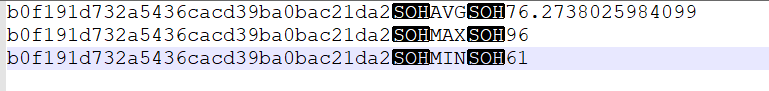





# FINAL Code:

   ### COUNTERS_ULL_TIME_DATA.csv   --  Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def parse_data(fname):
    """
    This method reads a .csv file and makes it into a dataframe.
    :fname:
    ::returns DataFrame Object
    """
    return pd.read_csv(fname)

In [4]:
# Data for BATTERY
data = parse_data("../data/temp/counters_ull_time_data.csv")

In [5]:
# Data Demographic
data['ID_INPUT'].value_counts()

3    5157
2    5157
1    5157
0    5157
Name: ID_INPUT, dtype: int64

In [6]:
data.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2020-11-21 00:49:47.838,0,1,0
1,2020-11-21 00:49:47.838,1,94,0
2,2020-11-21 00:49:47.838,2,0,0
3,2020-11-21 00:49:47.838,3,4294967295,0
4,2020-11-21 00:49:48.838,0,1,0


### Cleaning | Organizing Our Data

Since the data that we collect includes all values in the same column, to make it more clear to see, we choose to separate the values based on the ID_input and put them in a same row if the measurement_time is the same. 

Also since we don't need the measurement time for our analysis, the new dataset does not include the measurement time column. 

In [7]:
ac_status = data.loc[(data['ID_INPUT'] == 0)].reset_index()
battery_life = data.loc[(data['ID_INPUT'] == 1)].reset_index()
battery_saver = data.loc[(data['ID_INPUT'] == 2)].reset_index()
battery_time = data.loc[(data['ID_INPUT'] == 3)].reset_index()

In [8]:
d = {'AC': ac_status['VALUE'], 'Battery_life(%)': battery_life['VALUE'],
    'Battery_saver': battery_saver['VALUE'], 'Battery_time(seconds)': battery_time['VALUE']}

new_data = pd.DataFrame(data = d)
new_data.head()

,AC,Battery_life(%),Battery_saver,Battery_time(seconds)
0,1,94,0,4294967295
1,1,94,0,4294967295
2,1,94,0,4294967295
3,1,94,0,4294967295
4,1,94,0,4294967295


In [9]:
new_data['Battery_time(seconds)']

0       4294967295
1       4294967295
2       4294967295
3       4294967295
4       4294967295
           ...    
5152    4294967295
5153    4294967295
5154    4294967295
5155    4294967295
5156    4294967295
Name: Battery_time(seconds), Length: 5157, dtype: int64

In [10]:
battery_saver['VALUE'].unique()

array([0], dtype=int64)

### Defining a Methods for Data Analysis

In [11]:
def get_max_battery(data, column, value):
    """
    Description: returns the max battery percentage
    Parameters: data -> DataFrame, column -> Series Object, value -> Integer
    Returns: Max Value -> Integer
    """
    return data.loc[(data[column] == value)].max()

def get_min_battery(data, column, value):
    """
    Description: returns the min battery percentage
    Parameters: data -> DataFrame, column -> Series Object, value -> Integer
    Returns: Min Value -> Integer
    """
    return data.loc[(data[column] == value)].min()

def get_mean_battery(data, column, value):
    """
    Description: returns the mean battery percentage
    Parameters: data -> DataFrame, column -> Series Object, value -> Integer
    Returns: Mean Value -> Integer
    """
    return data.loc[(data[column] == value)].mean()

In [12]:
print(get_max_battery(data, "ID_INPUT", 1))
print(" ")
print("Here is the max value of our battery life %: 96%")

MEASUREMENT_TIME    2020-11-21 02:17:51.714
ID_INPUT                                  1
VALUE                                    96
PRIVATE_DATA                              0
dtype: object
 
Here is the max value of our battery life %: 96%


In [13]:
print(get_min_battery(data, "ID_INPUT", 1))
print(" ")
print("Here is the min value of our battery life %: 61%")

MEASUREMENT_TIME    2020-11-21 00:49:47.838
ID_INPUT                                  1
VALUE                                    61
PRIVATE_DATA                              0
dtype: object
 
Here is the min value of our battery life %: 61%


In [14]:
print(get_mean_battery(data, "ID_INPUT", 1))
print(" ")
print("Here is the mean value of our battery life %: 76.27%")

ID_INPUT         1.000000
VALUE           76.273803
PRIVATE_DATA     0.000000
dtype: float64
 
Here is the mean value of our battery life %: 76.27%


### COUNTERS_ULL_TIME_DATA.csv -- Graphical Analysis

For more clear to see the changes of battery_life value and AC Status, we plot two figures to represent the changes for each type of input data. Since values of battery_saver are all 0s which means the battery saver was not on during the process of collecting the data, we don't need to do analysis for this input.  Also since the values of battery life time are too big to show on the same figure standard, we don't include the battery life time values in the figures. 

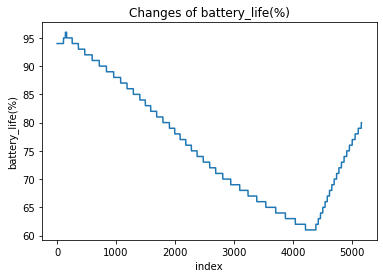

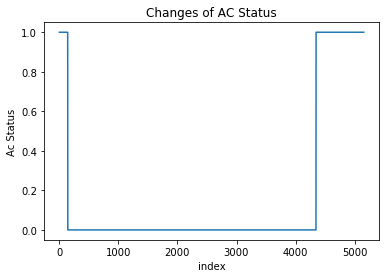

In [15]:
x = list(new_data.index)
y_1 = new_data['Battery_life(%)']
plt.figure(1)
plt.plot(x,y_1)
plt.title('Changes of battery_life(%)')
plt.xlabel('index')
plt.ylabel('battery_life(%)')

plt.figure(2)
y_2 = new_data['AC']
plt.plot(x,y_2)
plt.title('Changes of AC Status')
plt.xlabel('index')
plt.ylabel('Ac Status')

plt.show()

In [16]:
def plot_battery_life(data, column):
    """
    Description: plots a line graph of the battery life percentages.
    Parameters: data -> DataFrame, column -> Series Object
    Returns: Changes_of_battery_life.png -> file saved in root directory
    """
    x = list(data.index)
    y = data[column]
    plt.figure(1)
    plt.plot(x, y)
    plt.title("Changes of battery_life(%)")
    plt.xlabel('index')
    plt.ylabel('battery_life(%)')
    #return plt.show()
    return plt.savefig("data/out/Changes_of_battery_life.png")

def plot_ac_status(data, column):
    """
    Description: plots a line graph of the AC Status.
    Parameters: data -> DataFrame, column -> Series Object
    Returns: Changes_of_AC_Status.png -> file saved in root directory
    """
    x = list(data.index)
    y = data[column]
    plt.figure(2)
    plt.plot(x, y)
    plt.title('Changes of AC Status')
    plt.xlabel('index')
    plt.ylabel('AC Status')
    #return plt.show()
    return plt.savefig("data/out/Changes_of_AC_Status.png")

# Conslusion:


As we can see from the above figure, the battery_life was increasing then decreasing and then increasing, and the AC Status is changes from 1 to 0 and then from 0 to 1. 

The reason of those changes is that when we collected the data, at first we connected the AC power, so in the first part of changes, we can see that the values of battery_life status increasing and the values of AC status are equal to 1. Then we diconnected the AC power for a longer time, in this case we can see that the battery_life values status decreasing and the values of AC power are all equal to 0. After that, we reconnected the AC power and then we can see the values of battery_life is increasing and the values of AC status are equal to 1. 

One more thing that we found on the battery_life figures is that the slope of decreasing part is smaller than the increasing part. We can say that the battery_life has a more rapid change when the computer is connected to the AC Power. But our conclusion here might be lack of analysis since the battery_life is also related to the applications running on the computer when collect the data. 


# Contributions

Keshan:
    - data preparation
    - tabled data
    - key notes all throughout notebook
    - graphs + graph analysis
    - ATL work

Jon:
    - Report + main ideas
    - data analysis - code breakdown
    - repository structuring
    - notebook outlining
    - script writing
